Get coordinates for error ellipses, based on coordinates
x-error, y-error (1 sigma) and error correllation, and scaling 
factor (defaults to 95% confidence).

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl

Calculate major and minor axes and inclination of ellipse.
returns x_size, y_size, theta.

In [3]:
def calc_ellipse_params(x_err, y_err, rho, scale=2.4477):
    xy_err = rho * x_err * y_err
    covmat = np.matrix([[x_err**2,xy_err],
                        [xy_err, y_err**2]])

    eig = np.linalg.eigvals(covmat)

    theta  = 1/2 * math.atan((2*xy_err)/(x_err**2-y_err**2))
    x_size = eig[0]**0.5 * scale
    y_size = eig[1]**0.5 * scale
    if x_err >= y_err:
        theta = -theta
        
    return (x_size, y_size, theta)

In [4]:
def ellipse_formula(x,y,a,b,theta):
    x_t = lambda t: x + a*math.cos(t)*math.cos(theta) - b*math.sin(t)*math.sin(theta)
    y_t = lambda t: y + b*math.sin(t)*math.cos(theta) - a*math.cos(t)*math.sin(theta)
    return lambda t:[x_t(t), y_t(t)]

In [5]:
def ellipse(x,y,a,b,theta, num_pts=200):
    form = ellipse_formula(x,y,a,b,theta)
    return np.array([form(t) for t in np.linspace(0,2*math.pi, num=num_pts)][:-1])

Ellipse formula generator, similar to error ellipse, but returns a function taking an angle
(positive rotation direction) in degrees and returns the edge coordinate in that direction.

In [6]:
def error_ellipse_formula(x, y, x_err, y_err, rho, scale=2.4477):
    x_size, y_size, theta = calc_ellipse_params(x_err, y_err, rho, scale)

    return ellipse_formula(x,y,x_size,y_size,theta)

Takes data coordinates, 1 sigma errors, error correllation factor, scale
(95% conf default (2.4477), and number of edge points).
returns a coordinate matrix for for the error ellipse edges for each datapoint,
in data coordinates. 
This can be used for creating matplotlib patches.

In [7]:
def error_ellipse(x, y, x_err, y_err, rho, scale=2.4477, num_points = 200):
    x_size, y_size, theta = calc_ellipse_params(x_err, y_err, rho, scale)
    
    return ellipse(x,y,x_size,y_size,theta,num_points)

Example of plotting a data set:

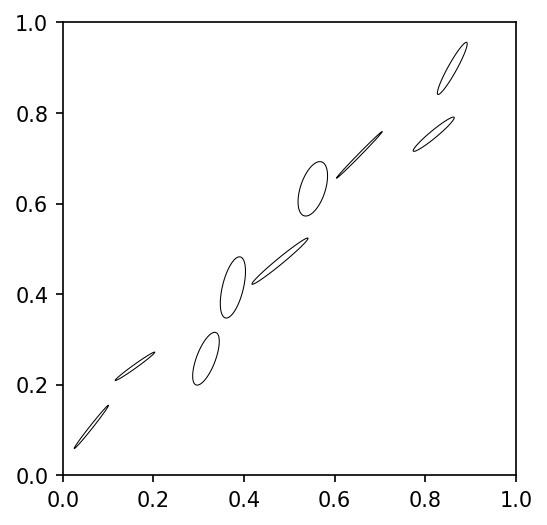

In [8]:
fig, ax = plt.subplots(dpi=150)
rng = np.random.RandomState(1129412)
for i in range(1,10):
    x, y = i/10 + (rng.rand()-0.5)/10, i/10+(rng.rand()-0.5)/10
    x_err, y_err = 0.01+rng.rand()/50, 0.01+rng.rand()/50
    rho = 0.7*rng.rand() + 0.2
    e_coords = error_ellipse(x, y, x_err, y_err, rho)
    e = mpl.patches.Polygon(e_coords, fc='none', ec='k', lw=0.5, joinstyle='round')
    ax.add_patch(e)
ax.set_aspect('equal')
plt.savefig('output_12_0.png');

In order to evaluate a regression fit, we calculate the 'best fit' distance, defined as the shortest distance from an analysis point, in relation to the error ellipse size. This corresponds to the distance between the ellipse center and the first point on the line the ellipse touches under scaling.

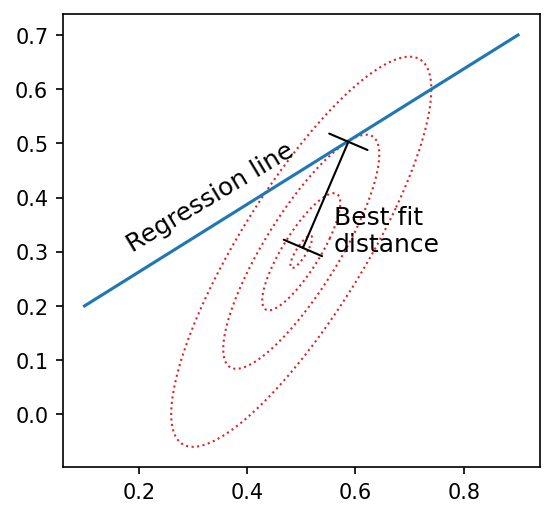

In [9]:
fig, ax = plt.subplots(dpi=150)
pts = [
    #x,   y,   x_err, y_err,  rho, scale
    [0.5, 0.3,  0.04,  0.06, 0.5, 0.5],
    [0.5, 0.3,  0.04,  0.06, 0.5, 1.8],
    [0.5, 0.3,  0.04,  0.06, 0.5, 3.6],
    [0.5, 0.3,  0.04,  0.06, 0.5, 6],
    
]
for pt in pts:
    e_coords = error_ellipse(*pt)
    e = mpl.patches.Polygon(e_coords, joinstyle='round', ls=':', fc='none', ec='C3', lw=1)
    ax.add_patch(e)

ax.plot([0.1,0.9], [0.2, 0.7]);
ax.annotate('', xy=(0.5,0.3), xytext=(0.59,0.51), xycoords='data', arrowprops={'arrowstyle': '|-|'})
ax.annotate('Best fit\ndistance', xy=(0.56,0.3), xycoords='data', fontsize=12)
ax.annotate('Regression line', xy=(0.17,0.3), c='k', xycoords='data', rotation =31, fontsize=12);
ax.set_aspect('equal')
plt.savefig('output_14_0.png');

In [10]:
def get_bestfitdist(x, y, x_err, y_err, rho, fit):
    
    shift_vec = np.matrix([[0,fit.y0]])
    l0 = np.matrix([[1,fit.alpha]])
    
    coords = np.array([[x,y]]) - shift_vec

    a, b, theta = calc_ellipse_params(
        x_err, y_err, rho)
    
    ellipse_form = ellipse_formula(
        x,y,a,b,theta)
    
    scale_mx_1 = np.matrix([[1,0],[0,b/a]])
    scale_mx_2 = np.matrix([[1,0],[0,a/b]])

    rot_mx = lambda t: np.matrix([[np.cos(t), - np.sin(t)],
                                  [np.sin(t), np.cos(t)]])
    
    c_pp = (coords@ rot_mx(theta) @scale_mx_1).T
    l0_pp =  (l0@ rot_mx(theta) @scale_mx_1).T
    l0_alpha = l0_pp[1,0]/l0_pp[0,0]
    n_pp = np.matrix([[-l0_pp[1,0],l0_pp[0,0]]]).T
    n_alpha = n_pp[1,0]/n_pp[0,0]
    n_0 = c_pp[1,0] - c_pp[0,0]*n_alpha
    
    x_intercept = n_0 / (l0_alpha-n_alpha)
    c_adj_pp = np.matrix([[x_intercept,l0_alpha*x_intercept]])
    
    n = ((n_pp.T * scale_mx_2) * rot_mx(-theta)) + shift_vec
    n = n/np.linalg.norm(n)
    c = ((c_pp.T * scale_mx_2) * rot_mx(-theta)) + shift_vec
    c_adj = ((c_adj_pp * scale_mx_2) * rot_mx(-theta)) + shift_vec
    theta_n = np.arccos(n[0,0])
    ell_coords = ellipse_form(theta_n)
    dir_95_conf = np.linalg.norm(np.array(c)[0]- np.array(ell_coords)) 
    misfit = np.linalg.norm(c-c_adj) * (1 if c[0,0] >= c_adj[0,0] else -1) 
    return (c_adj, misfit, n, theta_n, dir_95_conf)